In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, roc_curve, precision_recall_curve, plot_precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import ensemble
import warnings
warnings.filterwarnings("ignore") 
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import precision_recall_curve

! pip install bayesian-optimization
! pip install tabulate
from tabulate import tabulate

from bayes_opt import BayesianOptimization
import lightgbm as lgb

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=33e29debbab2d37df23283d0eaa17a6759b567eb7bb5a4ae25359e16ae36af1c
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [2]:
# read in csv file

df = pd.read_csv('https://raw.githubusercontent.com/ihbthink/ds_class/master/train.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

Data cleaning

In [3]:
# remove unnamed and id columns as they do not contribute

df.drop(['Unnamed: 0','id'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [4]:
# replace NaN values in arrival delays with values in departure delays

print('Number of NaN before transform: ',df['Arrival Delay in Minutes'].isna().sum())
df['Arrival Delay in Minutes'].fillna(df['Departure Delay in Minutes'], inplace=True)
print('Number of NaN after transorm: ',df['Arrival Delay in Minutes'].isna().sum())

Number of NaN before transform:  310
Number of NaN after transorm:  0


In [5]:
# make copy of df to be used later

df2 = df.copy()

# flight distance, age and gender can't be controlled or influenced by the airline, so remove for model

df.drop(['Flight Distance','Age','Gender'], axis=1, inplace=True)

# Arrival Delay in Minutes is highly correlated with Departure Delay in Minutes, so drop Arrival Delay

df.drop(['Arrival Delay in Minutes'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Customer Type                      103904 non-null  object
 1   Type of Travel                     103904 non-null  object
 2   Class                              103904 non-null  object
 3   Inflight wifi service              103904 non-null  int64 
 4   Departure/Arrival time convenient  103904 non-null  int64 
 5   Ease of Online booking             103904 non-null  int64 
 6   Gate location                      103904 non-null  int64 
 7   Food and drink                     103904 non-null  int64 
 8   Online boarding                    103904 non-null  int64 
 9   Seat comfort                       103904 non-null  int64 
 10  Inflight entertainment             103904 non-null  int64 
 11  On-board service                   103904 non-null  

Create test/train data sets and scale appropriately.

In [ ]:
# create train/test data

X = df.drop(['satisfaction'],axis=1)
y = df['satisfaction']

# one hot encode categorical features; keep first column so it will be used in model
X = pd.concat([X, pd.get_dummies(X.select_dtypes('object'))], axis=1)
X.drop(X.select_dtypes('object'),axis=1,inplace=True)

# convert target variable to integer (1 = satiesfied, 0 = neutral or dissatisfied)
y = np.where(y == 'satisfied', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# scale X data sets

scaler = RobustScaler()
X_trainsc = scaler.fit_transform(X_train)
X_testsc = scaler.transform(X_test)

Create a baseline model with DummyClassifier.

In [ ]:
# create a baseline model for reference

y_train

dummy = DummyClassifier(strategy='most_frequent',random_state=0)
dummy.fit(X_trainsc,y_train)
y_pred = dummy.predict(X_testsc)

print(classification_report(y_test, y_pred, target_names=['neutral or dissatisfied','satisfied']))


                         precision    recall  f1-score   support

neutral or dissatisfied       0.57      1.00      0.73     11823
              satisfied       0.00      0.00      0.00      8958

               accuracy                           0.57     20781
              macro avg       0.28      0.50      0.36     20781
           weighted avg       0.32      0.57      0.41     20781



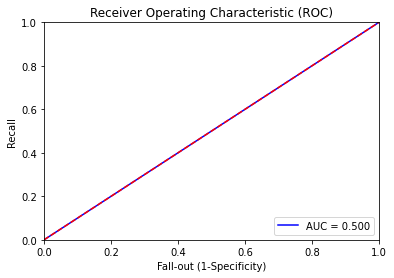

AUC score: 0.5


In [ ]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

I will use Bayesian optimization to find best hyperparameters for several types of models.

Light GBM model

In [ ]:
#  LightGBM optimization

def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
        "objective" : "binary",
        "metric" : "auc", 
        'is_unbalance': True,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "num_threads" : 20,
        "min_child_samples" : int(min_child_samples),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : 0.03,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(X_trainsc, y_train)
    cv_result = lgb.cv(params,
                       lgtrain,
                       1000,
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    return cv_result['auc-mean'][-1]

In [ ]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (25, 4000),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 0.05),
                                                'lambda_l1': (0.0, 0.05),
                                                'min_child_samples': (50, 10000),
                                                'min_data_in_leaf': (100, 2000)
                                                })

lgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.9941   |  0.04039  |  0.04853  |  30.08    |  5.183e+0 |  1.63e+03 |  1.986e+0 |
|  2        |  0.9941   |  0.007447 |  0.005747 |  20.28    |  1.264e+0 |  1.557e+0 |  2.52e+03 |


In [ ]:
lgbBO.max

{'params': {'lambda_l1': 0.02795617014704946,
  'lambda_l2': 0.04525458183819037,
  'max_depth': 43.6042789757437,
  'min_child_samples': 7026.570828529086,
  'min_data_in_leaf': 265.73873261495396,
  'num_leaves': 501.6035621966329},
 'target': 0.9945887400676213}

In [ ]:
# apply optimized parameters to model

d_train = lgb.Dataset(X_trainsc, y_train)

d_params = {}
d_params['num_leaves']= 502
d_params['max_depth']= 44
d_params['lambda_l2']= 0.045
d_params['lambda_l1']= 0.028
d_params['min_child_samples']= 7027
d_params['min_data_in_leaf']= 266

lgbm = lgb.train(d_params, d_train, 100)


In [ ]:
# make predictions

y_pred = lgbm.predict(X_testsc)

#convert into binary values

for i in range(0,20781):
    if (y_pred[i] >= 0.5):
        y_pred[i] = 1
    else:
        y_pred[i] =0
len(y_pred)  

print(classification_report(y_test, y_pred, target_names=['neutral or dissatisfied','satisfied']))


                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.98      0.96     11773
              satisfied       0.97      0.93      0.95      9008

               accuracy                           0.96     20781
              macro avg       0.96      0.95      0.96     20781
           weighted avg       0.96      0.96      0.96     20781



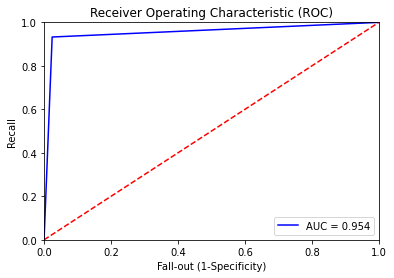

AUC score: 0.9542462298204987


In [ ]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)


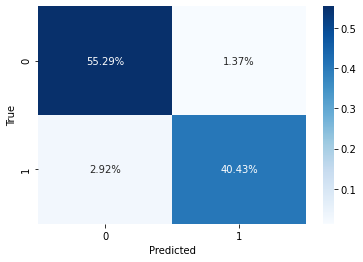

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Random Forest Classifier model

In [ ]:
# random forest classifier optimization

space_rf = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space_rf):
    model = RandomForestClassifier(criterion = space_rf['criterion'], 
                                   max_depth = space_rf['max_depth'],
                                 max_features = space_rf['max_features'],
                                 min_samples_leaf = space_rf['min_samples_leaf'],
                                 min_samples_split = space_rf['min_samples_split'],
                                 n_estimators = space_rf['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_trainsc, y_train, cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space_rf,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|██████████| 80/80 [52:10<00:00, 39.14s/it, best loss: -0.932846500206401]


{'criterion': 0,
 'max_depth': 170.0,
 'max_features': 2,
 'min_samples_leaf': 0.0011881345076161925,
 'min_samples_split': 0.006671791558201738,
 'n_estimators': 3}

In [ ]:
rfbo = RandomForestClassifier(criterion='entropy', max_depth=170, max_features=2,min_samples_leaf=0.001, min_samples_split=0.007, n_estimators=750)
rfbo.fit(X_trainsc,y_train)
y_pred = rfbo.predict(X_testsc)

print(classification_report(y_test, y_pred, target_names=['neutral or dissatisfied','satisfied']))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.91      0.95      0.93     11773
              satisfied       0.93      0.88      0.90      9008

               accuracy                           0.92     20781
              macro avg       0.92      0.92      0.92     20781
           weighted avg       0.92      0.92      0.92     20781



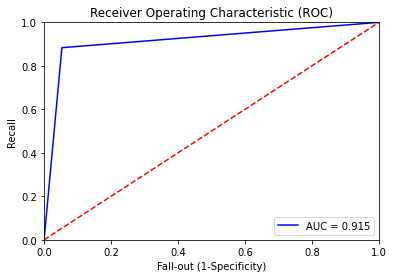

AUC score: 0.9151452519379698


In [ ]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

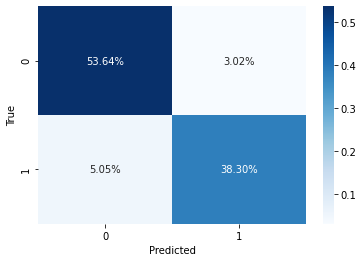

In [ ]:
# generate confusion matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Logistic regresssion model


In [ ]:
# Logistic regression optimization

space_lr = {
    'C' : hp.uniform('C', 0.05, 3),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000))
}

def objective(space_lr):
    lr = LogisticRegression( C = space_lr['C'], 
                                max_iter= space_lr['max_iter'],
                                solver = space_lr['solver'])

    accuracy_lr = cross_val_score(lr, X_trainsc, y_train, cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy_lr, 'status': STATUS_OK }
    
trials = Trials()
best_lr = fmin(fn= objective,
            space= space_lr,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best_lr

100%|██████████| 80/80 [04:53<00:00,  3.67s/it, best loss: -0.8742947552780014]


{'C': 0.05263521127516863, 'max_iter': 655, 'solver': 2}

In [ ]:
# print classification report

lrbo = LogisticRegression(C=0.05, max_iter= 655, solver= 'liblinear')
lrbo.fit(X_trainsc,y_train)
y_pred = lrbo.predict(X_testsc)

print(classification_report(y_test, y_pred, target_names=['neutral or dissatisfied','satisfied']))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.88      0.90      0.89     11773
              satisfied       0.86      0.84      0.85      9008

               accuracy                           0.87     20781
              macro avg       0.87      0.87      0.87     20781
           weighted avg       0.87      0.87      0.87     20781



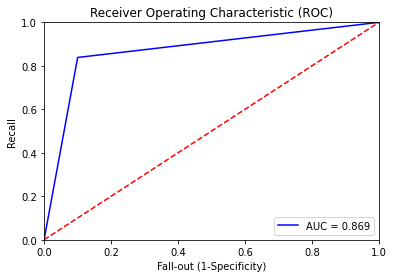

AUC score: 0.8691368217067714


In [ ]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

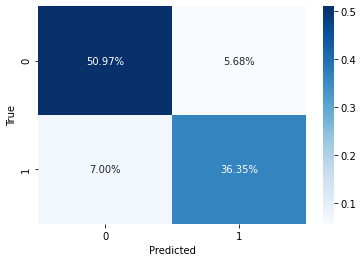

In [ ]:
# generate confusion matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Create table comparing model results:

In [ ]:
table = [['Light GBM','0.96','0.96','0.96','0.95'],['Random Forest','0.92','0.92','0.92','0.92'],['Logistic Regression','0.87','0.87','0.87','0.87'],['Dummy','0.32','0.57','0.41','0.50']]

print(tabulate(table, headers=['Classifier','Precision','Recall','F1','AUC'], tablefmt='presto'))

 Classifier          |   Precision |   Recall |   F1 |   AUC
---------------------+-------------+----------+------+-------
 Light GBM           |        0.96 |     0.96 | 0.96 |  0.95
 Random Forest       |        0.92 |     0.92 | 0.92 |  0.92
 Logistic Regression |        0.87 |     0.87 | 0.87 |  0.87
 Dummy               |        0.32 |     0.57 | 0.41 |  0.5


The Light GBM model outperforms the others in precision, recall, F1 and AUC scoring.  It will be the best model to use.

[1769 1212  940 1161  856 1321 1267  926 1129 1239 1234 1381 1213  954
 1488  346    1  375    2  511  169   32]


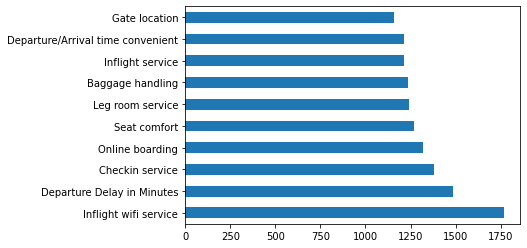

In [ ]:
# Feature importance of Light GBM model

print(lgbm.feature_importance())

feat_importances = pd.Series(lgbm.feature_importance(), index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The five most important features to the Light GBM model are: inflight wifi rating, departure delay, checkin service rating, online boarding rating and seat comfort. 